### Loading dataset from CICDDoS2019 and balancing it. Plus, Scaling data points and splitting data

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler

df = pd.read_csv("CICDDoS2019_Syn.csv")
df.columns=df.columns.str.strip()

#using the selected features
selectedFeatures=['Destination Port', 'Total Length of Bwd Packets','Bwd Packet Length Std', 'Flow IAT Mean', 'Bwd Packets/s','Packet Length Mean', 'Label']
df=df[selectedFeatures]

# Create a RandomUnderSampler object
under_sampler = RandomUnderSampler(sampling_strategy={'Syn': 35790}, random_state=42)

# Split the features (X) and the target (y)
X = df.drop('Label', axis=1)  # Replace with your actual feature columns
y = df['Label']

# Perform undersampling
X_resampled, y_resampled = under_sampler.fit_resample(X, y)

# Combine the resampled features and labels back into a DataFrame
df = pd.DataFrame(X_resampled, columns=X.columns)
df['Label'] = y_resampled
# Now df_resampled contains a balanced dataset

df["Label"].replace(["BENIGN","Syn"],[0,1],inplace=True)

X = MinMaxScaler().fit_transform(df.drop(['Label'],axis=1))
y=df["Label"]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,stratify=y)

C:\Users\dyari\AppData\Local\Temp\ipykernel_15664\3247416133.py:8: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("CICDDoS2019_Syn.csv")
C:\Users\dyari\AppData\Local\Temp\ipykernel_15664\3247416133.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Label"].replace(["BENIGN","Syn"],[0,1],inplace=True)
C:\Users\dyari\AppData\Local\Temp\ipykernel_15664\3247416133.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed 

### Training the MLP model

In [5]:
from sklearn.neural_network import MLPClassifier
import time

clf = MLPClassifier(hidden_layer_sizes=(100,200,250),
                    max_iter=100,solver="adam",
                    verbose=True,activation='relu',
                    learning_rate_init=0.01)

start_time = time.time()
# Fit data onto the model
clf.fit(X_train,y_train)

end_time = time.time()
elapsed_time = end_time - start_time

Iteration 1, loss = 0.25817227
Iteration 2, loss = 0.22291251
Iteration 3, loss = 0.21815932
Iteration 4, loss = 0.21591557
Iteration 5, loss = 0.20662506
Iteration 6, loss = 0.21221787
Iteration 7, loss = 0.19517323
Iteration 8, loss = 0.21386341
Iteration 9, loss = 0.20163729
Iteration 10, loss = 0.19804504
Iteration 11, loss = 0.15384389
Iteration 12, loss = 0.14366912
Iteration 13, loss = 0.13061458
Iteration 14, loss = 0.13142546
Iteration 15, loss = 0.12233536
Iteration 16, loss = 0.12364801
Iteration 17, loss = 0.12092805
Iteration 18, loss = 0.11825215
Iteration 19, loss = 0.11900139
Iteration 20, loss = 0.11777683
Iteration 21, loss = 0.14044462
Iteration 22, loss = 0.17640790
Iteration 23, loss = 0.12889517
Iteration 24, loss = 0.12170571
Iteration 25, loss = 0.12010340
Iteration 26, loss = 0.11753035
Iteration 27, loss = 0.11492820
Iteration 28, loss = 0.11742757
Iteration 29, loss = 0.11256098
Iteration 30, loss = 0.11485817
Iteration 31, loss = 0.11301616
Iteration 32, los

### Predictions BEFORE sample modification

Accuracy: 0.9399273540094999
---------------------------------------------------------


array([[6713,  445],
       [ 415, 6743]], dtype=int64)

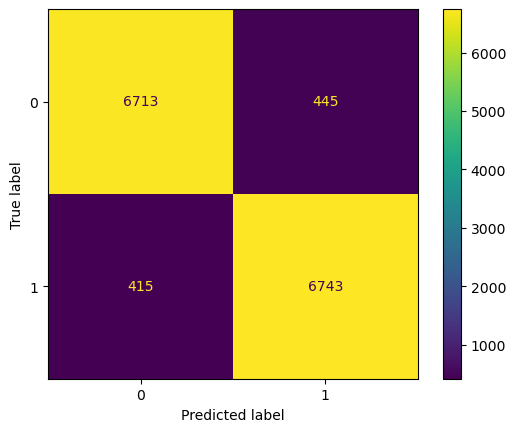

In [7]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,f1_score,recall_score

y_pred=clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test,y_pred))
print("---------------------------------------------------------")

BeforePerturbation = ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
BeforePerturbation.confusion_matrix

### Sample modification - Both Benign and Malicious Shuffle

In [9]:
import random

#Identify the unique 'Flow IAT Mean' values of all classes
unique_values = df['Flow IAT Mean'].unique()

random.seed(42)

def SystematicShuffling(X, y, feature='Flow IAT Mean'):
    # Ensure X and y are pandas DataFrames and Series
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X, columns=df.drop(columns=['Label']).columns)
    if isinstance(y, np.ndarray):
        y = pd.Series(y)

    X_copy = X.copy()
    y_copy = y.copy()

    # Loop through the dataset
    for idx in range(len(X)):
        X_copy.loc[idx, feature] = random.choice(unique_values)

    return X_copy, y_copy


X_evasive3, y_evasive3 = SystematicShuffling(X_test, y_test, feature='Flow IAT Mean')

### Predictions After sample modification - Both Benign and Malicious Shuffle

C:\Users\dyari\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


Accuracy: 0.5000698519139425
---------------------------------------------------------


array([[7158,    0],
       [7157,    1]], dtype=int64)

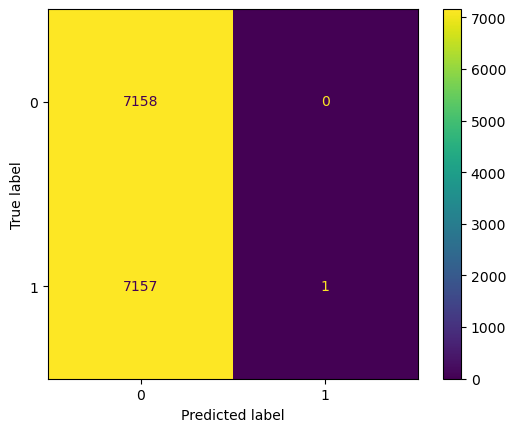

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,f1_score,recall_score

y_pred3_evasive = clf.predict(X_evasive3)

print("Accuracy:", accuracy_score(y_evasive3,y_pred3_evasive))
print("---------------------------------------------------------")


Perturb03=ConfusionMatrixDisplay.from_predictions(y_evasive3, y_pred3_evasive)
Perturb03.confusion_matrix